In [1]:
# load pandas and numpy
import pandas as pd
import numpy as np
import re
import os
import seaborn as sns

def get_tables(is_covariates, models, datasets, time_steps):
    # create dataframes for MSE and MAE with columns for each dataset and rows for each model
    df_rmse = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] + 
                        [dataset + ' OD' for dataset in datasets], index=models)
    df_mae = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OD' for dataset in datasets], index=models)
    df_likelihood = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OD' for dataset in datasets], index=models[1:]) # no likelihood for ARIMA
    df_calibration = pd.DataFrame(columns=[dataset + ' ID' for dataset in datasets] +
                            [dataset + ' OD' for dataset in datasets], index=models[1:]) # no calibration for ARIMA
    
    error_bars = pd.DataFrame(columns=["dataset", "model", "type", "error_type", "error_value"])

    for model in models:
        for dataset in datasets:
            filename = f"../output/{model}_{dataset}.txt" if not is_covariates else f"../output/{model}_covariates_{dataset}.txt"

            if not os.path.isfile(filename):
                print(filename)
                continue

            with open(filename, 'r') as f:
                for line in f:
                    if line.startswith('ID median of (MSE, MAE):'):
                        id_mse_mae = re.findall(r"\d+\.\d+(?:e-\d+)?", line)
                        print(model, filename, id_mse_mae)
                        df_rmse.loc[model, dataset + ' ID'] = float(id_mse_mae[0])**0.5
                        df_mae.loc[model, dataset + ' ID'] = float(id_mse_mae[1])

                        if len(id_mse_mae) > 2:
                            error_bars.loc[len(error_bars)] = [dataset, model, "ID", "RMSE", float(id_mse_mae[3])*1.96]

                    elif line.startswith('OOD median of (MSE, MAE):'):
                        od_mse_mae = re.findall(r'\d+\.\d+(?:e-\d+)?', line)
                        df_rmse.loc[model, dataset + ' OD'] = float(od_mse_mae[0])**0.5
                        df_mae.loc[model, dataset + ' OD'] = float(od_mse_mae[1])
                        
                        if len(od_mse_mae) > 2:
                            error_bars.loc[len(error_bars)] = [dataset, model, "OD", "RMSE", float(od_mse_mae[3])*1.96]
                        
                    elif line.startswith('ID likelihoods:'):
                        id_likelihoods = re.findall(r'-?\d+\.\d+', line)
                        df_likelihood.loc[model, dataset + ' ID'] = float(id_likelihoods[0])

                    elif line.startswith('OOD likelihoods:'):
                        ood_likelihoods = re.findall(r'-?\d+\.\d+', line)
                        df_likelihood.loc[model, dataset + ' OOD'] = float(ood_likelihoods[0])

                    elif line.startswith('ID calibration errors:'):
                        id_calib = re.findall(r'-?\d+\.\d+', line)
                        id_calib = np.mean([float(x) for x in id_calib[:time_steps]])
                        df_calibration.loc[model, dataset + ' ID'] = id_calib

                    elif line.startswith('OOD calibration errors:'):
                        ood_calib = re.findall(r'-?\d+\.\d+', line)
                        ood_calib = np.mean([float(x) for x in ood_calib[:time_steps]])
                        df_calibration.loc[model, dataset + ' OD'] = ood_calib
    
    # sort columns for all dataframes
    df_rmse = df_rmse.reindex(sorted(df_rmse.columns), axis=1)
    df_mae = df_mae.reindex(sorted(df_mae.columns), axis=1)
    df_likelihood = df_likelihood.reindex(sorted(df_likelihood.columns), axis=1)
    df_calibration = df_calibration.reindex(sorted(df_calibration.columns), axis=1)

    return df_rmse, df_mae, df_likelihood, df_calibration, error_bars

models = ['arima', 'nhits', 'tft', 'linreg', 'xgboost', 'transformer', 'gluformer', "latentode"]
datasets = ['weinstock', 'dubosson', 'colas', 'iglu', 'hall']
time_steps = 12

df_nocov_rmse, df_nocov_mae, _, _, error_bars_nocov = get_tables(False, models, datasets, time_steps) 

nocovmodels = [m for m in models if m != "arima"]
df_cov_rmse, df_cov_mae, _, _, error_bars_cov = get_tables(True, models, datasets, time_steps) 

arima ../output/arima_weinstock.txt ['179.54016523897357', '11.248462923994717']
arima ../output/arima_dubosson.txt ['183.1096725417644', '11.059067918537597']
arima ../output/arima_colas.txt ['33.59905020645601', '4.803567750156345']
arima ../output/arima_iglu.txt ['110.89655963565743', '8.667667482799056']
arima ../output/arima_hall.txt ['74.52169492045664', '7.341406919669163']
nhits ../output/nhits_weinstock.txt ['176.60296630859375', '11.208269119262695', '1.9527196884155273', '0.06575722992420197']
nhits ../output/nhits_dubosson.txt ['304.59716796875', '14.788917541503906', '1.1638996601104736', '0.04914090037345886']
nhits ../output/nhits_colas.txt ['35.203372955322266', '5.038236618041992', '0.25768163800239563', '0.01612761802971363']
nhits ../output/nhits_iglu.txt ['190.20445251464844', '12.07038402557373', '9.070531845092773', '0.30826225876808167']
nhits ../output/nhits_hall.txt ['59.021507263183594', '6.567608833312988', '0.2712828814983368', '0.018614130094647408']
tft ..

In [2]:
def rename_data(df):
    df = df.replace({
        'arima': 'AR.',
        'nhits': 'NHiTS',
        'tft': 'TFT',
        'linreg': 'Regres.',
        'xgboost': 'XGBoost',
        'transformer': 'Transf.',
        'gluformer': 'Gluformer', # TODO: update
        'latentode': 'L-ODE', # TODO: update
        'colas': 'Colas',
        'dubosson': 'Dubosson',
        'hall': 'Hall',
        'iglu': 'Broll',
        'weinstock': 'Weinstock',
    }, regex=True)
    
    return df

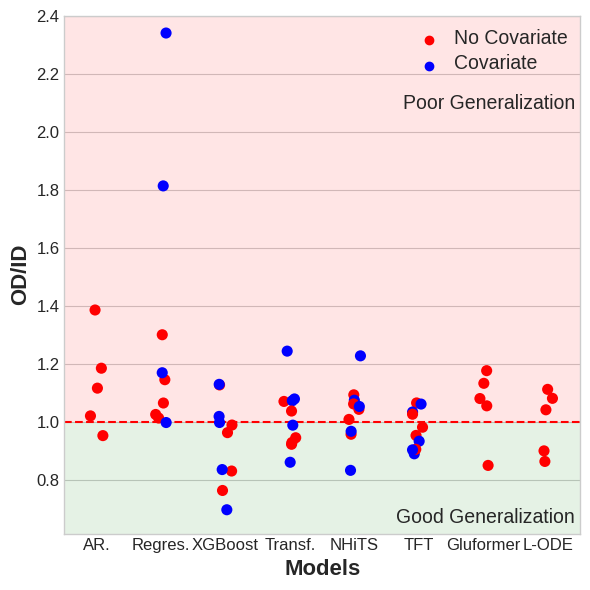

In [22]:
import matplotlib.pyplot as plt
# use whitegrid theme from seaborn
plt.style.use('seaborn-whitegrid')

# 2. ID compared to OOD - axis along datasets
ratios = pd.DataFrame()

for model in models:
    od_div_id = []

    for dataset in datasets:
        delta_nocov = df_nocov_rmse.filter(items=[model], axis=0)[f"{dataset} OD"]/df_nocov_rmse.filter(items=[model], axis=0)[f"{dataset} ID"]
        delta_cov = df_cov_rmse.filter(items=[model], axis=0)[f"{dataset} OD"]/df_cov_rmse.filter(items=[model], axis=0)[f"{dataset} ID"]

        od_div_id.append((delta_nocov.index.values[0], delta_nocov[0], "No Covariate"))
        od_div_id.append((delta_cov.index.values[0], delta_cov[0], "Covariate"))

    ratios = pd.concat([ratios, pd.DataFrame(od_div_id)])

df = ratios.dropna()
df = df[df[1] < 10]
df = rename_data(df)
df

fig, ax = plt.subplots(figsize=(6,6))
sns.stripplot(
    df,
    x=df[0],
    y=1,
    order=["AR.","Regres.","XGBoost","Transf.","NHiTS","TFT", "Gluformer", "L-ODE"], # TODO: update w/ gluformer & latent ode 
    hue=2, 
    size=8,
    palette=["r", "b"],
    ax=ax
)

ax.axhline(1, color="red", linestyle="--")
ax.set_ylabel("OD/ID", weight=900)
ax.set_xlabel("Models", weight=900)
ax.set_ylim(bottom=None, top=2.4)
ax.axhspan(1, 2.5, facecolor="red", alpha=0.1)
ax.axhspan(0, 1, facecolor="green", alpha=0.1)
# put text in corners with font size 22
ax.text(0.99, 0.85, "Poor Generalization", ha='right', va='top', transform=ax.transAxes, fontsize=14)
ax.text(0.99, 0.05, "Good Generalization", ha='right', va='top', transform=ax.transAxes, fontsize=14)
ax.legend(loc="upper right")

# increase font size of all text
for item in ([ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(16)
for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(12)
for item in ax.get_legend().get_texts():
        item.set_fontsize(14)
plt.tight_layout()
plt.savefig("./plots/njf/od_id_ratio.pdf")


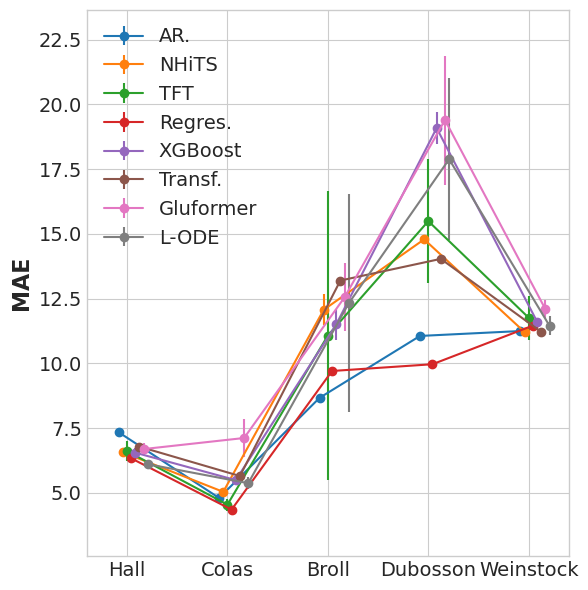

In [26]:
def prepare_data(df):
    df = df.stack().reset_index()
    df["type"] = df["level_1"].apply(lambda x: "ID" if "ID" in x else "OOD")
    df = df[df["type"] == "ID"]
    df.columns = ["model", "dataset", "error", "type"]
    df["dataset"] = df["dataset"].apply(lambda x: x.split(" ")[0])

    return df

order = ["Hall","Colas","Broll","Dubosson","Weinstock"]
error_bars_nocov = rename_data(error_bars_nocov)

temp_df = rename_data(prepare_data(df_nocov_mae))
temp_df = pd.merge(temp_df, error_bars_nocov[["model", "dataset", "type","error_value"]], on=["model","dataset","type"], how="left").fillna(0)
df_nocov = temp_df.sort_values(by="dataset", key= lambda x: x.map({val: key for key, val in list(enumerate(order))}))

import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Arial'

fig, ax = plt.subplots(figsize=(6, 6))  # Change figsize as needed

offset = lambda p: transforms.ScaledTranslation(p/72., 0, fig.dpi_scale_trans)
trans = ax.transData

for i, m in enumerate(["AR.", "NHiTS", "TFT", "Regres.", "XGBoost", "Transf.", "Gluformer", "L-ODE"]): # TODO: update w/ gluformer
    df = df_nocov[df_nocov["model"] == m]
    ax.errorbar(
        df["dataset"], 
        df["error"], 
        xerr=None, 
        yerr=df["error_value"], 
        label=m,
        markersize=6,
        fmt="-o",
        transform=trans+offset((i-2)*3)
    )

ax.set_ylabel("MAE", fontsize=16, fontweight="bold")
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(prop={'size': 14})
ax.margins(0.1)

plt.tight_layout()
plt.savefig("./plots/njf/generalization_by_diabetic.pdf")

In [5]:
# 3. LOTS OF PLOTS


df1 = rename_data(prepare_data(df_nocov_rmse))

print(df1)

# 3a.Ordered by difficulty

#  ID vs. OOD
# plt.figure()
# sns.boxenplot(df1, x="model", y="error", hue="type")

        model    dataset      error type
0         AR.      Colas   5.796469   ID
2         AR.   Dubosson  13.531802   ID
4         AR.       Hall   8.632595   ID
6         AR.      Broll  10.530744   ID
8         AR.  Weinstock  13.399260   ID
10      NHiTS      Colas   5.933243   ID
12      NHiTS   Dubosson  17.452712   ID
14      NHiTS       Hall   7.682546   ID
16      NHiTS      Broll  13.791463   ID
18      NHiTS  Weinstock  13.289205   ID
20        TFT      Colas   5.619780   ID
22        TFT   Dubosson  18.365973   ID
24        TFT       Hall   7.916066   ID
26        TFT      Broll  13.734609   ID
28        TFT  Weinstock  14.324450   ID
30    Regres.      Colas   5.263553   ID
32    Regres.   Dubosson  12.068422   ID
34    Regres.       Hall   7.383182   ID
36    Regres.      Broll  11.682952   ID
38    Regres.  Weinstock  13.602916   ID
40    XGBoost      Colas   6.421443   ID
42    XGBoost   Dubosson  21.176230   ID
44    XGBoost       Hall   7.579501   ID
46    XGBoost   